##Preproses

In [3]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.spatial
!pip install haversine
!pip install opencage
from haversine import haversine
from opencage.geocoder import OpenCageGeocode
import folium
from folium.plugins import FastMarkerCluster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 4.0 MB 10.3 MB/s 


In [4]:
from google.colab import files
df = files.upload()
for fn in df.keys():
  print('Nama file"{name}" dengan panjang {length} bytes'.format(name=fn, length=len(df[fn])))

Saving city_data.csv to city_data.csv
Nama file"city_data.csv" dengan panjang 5604 bytes


In [5]:
data = pd.read_csv('city_data.csv')
data.head()

,name,longitude,latitude,population
0,Kabupaten Pandeglang,106.103897,-6.314835,1209011
1,Kabupaten Lebak,106.252214,-6.564396,1295810
2,Kabupaten Tangerang,106.631889,-6.178306,3692693
3,Kabupaten Serang,106.150299,-6.120090,1501501
4,Kota Tangerang Selatan,106.718056,-6.288889,1696308


In [6]:
print(data.isnull().sum())
print("Total Null values count: ", data.isnull().sum().sum())

name          0
longitude     0
latitude      0
population    0
dtype: int64
Total Null values count:  0


In [7]:
data.duplicated().sum()

0

In [8]:
data.loc[data.duplicated(), :]

,name,longitude,latitude,population


In [9]:
data.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


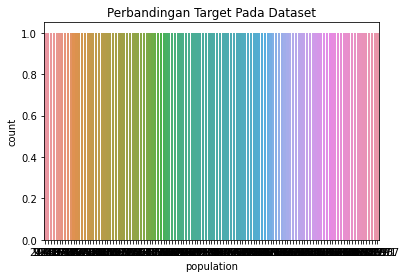

In [10]:
import seaborn as sns
y = data["population"]
sns.countplot(y).set_title('Perbandingan Target Pada Dataset')
target_temp = data.population.value_counts()

In [31]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only



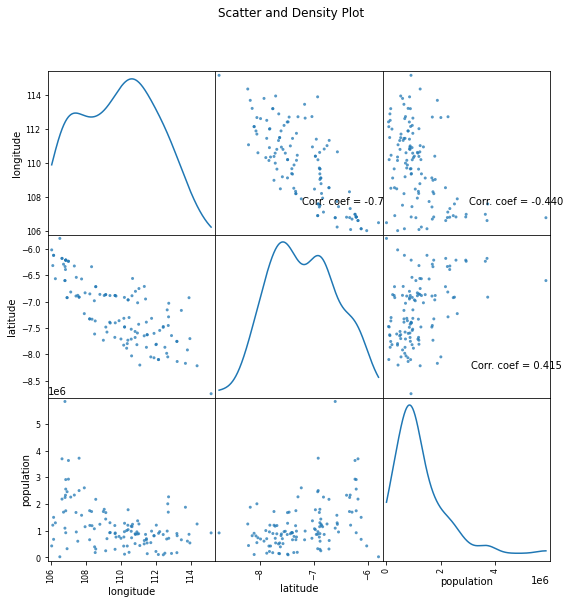

In [32]:
plotScatterMatrix(data, 9, 10)

In [13]:
lats=data['latitude'].to_list()
lons=data['longitude'].to_list()

In [18]:
m= folium.Map(
    location=[111.7615,-7.3175],
    zoom_start=4.4,tiles='Stamen Toner')
#FastMarkerCluster(data[['latitudes', 'longitudes']].values.tolist()).add_to(m)
folium.LayerControl().add_to(m)

for row in data.iterrows():
    row=row[1]
    folium.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius= row['population']/7500,
                        color="#007849",
                        popup=row['name'],
                        fill=False).add_to(m)


# save the map 
#m.save("save_file.html")
    
display(m)

In [30]:
import plotly.graph_objects as go

data['text'] = data['name'] +'Populasi:'+ data['population'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        locations = ["Indonesia"],
        locationmode = 'country names',
        lon = data['longitude'],
        lat = data['latitude'],
        text = data['text'],
        mode = 'markers',
        marker = dict(
            size = data['population']/5000,
            opacity = 0.8,
            reversescale=True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = data['population'],
            cmax = data['population'].max(),
            colorbar_title="Populasi<br>count per bounty"
        )))

fig.update_layout(
        title = 'Kabupaten di indonesia<br>()',
        geo = dict(
            scope='asia',
            projection_type='kavrayskiy7',
            showland = True
        ),
    )
fig.show()

##Implementasi Program

In [33]:
def jarak(p1,p2):
  return haversine(p1[1:],p2[1:])
def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append(np.average(data[clusters == i],weights=np.squeeze(np.asarray(data[clusters == i][:,[0]])),axis=0))
  return results
def kmeans(data, k=None, centroids=None, iter=30):
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]
  elbow = []
  for _ in range(max(iter, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: (jarak(u,v)**2))
    clusters = np.argmin(sqdists, axis=0)
    centroid_baru = cluster_centroids(data, clusters, k)
    if np.array_equal(centroid_baru, centroids):
      break
    centroids = centroid_baru
  return clusters, centroids, elbow

In [34]:
vals = data[['population','latitude','longitude']].values
sse=[]
for k in range(1,11):
    clusters,centroids,elbow=kmeans(vals,k)
    sqdist = np.sum((elbow-np.mean(elbow))**2)
    sse.append(sqdist)
sse=sorted(sse,reverse=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



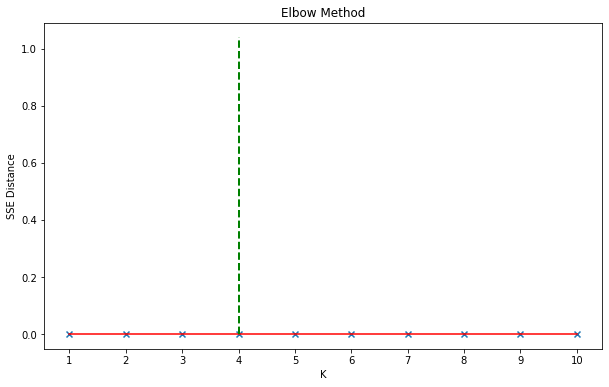

<Figure size 432x288 with 0 Axes>

In [35]:
fig = plt.figure(figsize=(10,6))
x=list(range(1,11))
labels=x
plt.plot(x,sse,'r')
plt.scatter(x,sse,marker='x')
plt.xticks(x, labels)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE Distance')
plt.plot([4, 4], [0,1.04 ],color='green',
         linestyle='dashed',linewidth=2)    
plt.show()
plt.savefig('elbow.png')

In [36]:
k = 4
random.seed(42)
clusters,centroids,elbow=kmeans(vals,k)
#output
data['c']=[int(c) for c in clusters]
lats = [centroids[i][1] for i in range(k)]
data['clat'] = data['c'].map(lambda x: lats[x])
longs = [centroids[i][2] for i in range(k)]
data['clong'] = data['c'].map(lambda x: longs[x])
data.head()
data

,name,longitude,latitude,population,text,c,clat,clong
0,Kabupaten Pandeglang,106.103897,-6.314835,1209011,Kabupaten PandeglangPopulasi:1209011,3,-6.458597,106.945660
1,Kabupaten Lebak,106.252214,-6.564396,1295810,Kabupaten LebakPopulasi:1295810,3,-6.458597,106.945660
2,Kabupaten Tangerang,106.631889,-6.178306,3692693,Kabupaten TangerangPopulasi:3692693,3,-6.458597,106.945660
3,Kabupaten Serang,106.150299,-6.120090,1501501,Kabupaten SerangPopulasi:1501501,3,-6.458597,106.945660
4,Kota Tangerang Selatan,106.718056,-6.288889,1696308,Kota Tangerang SelatanPopulasi:1696308,3,-6.458597,106.945660
...,...,...,...,...,...,...,...,...
114,Kota Malang,112.626503,-7.981894,689812,Kota MalangPopulasi:689812,0,-7.743040,112.984721
115,Kota Batu,112.523900,-7.867100,159525,Kota BatuPopulasi:159525,0,-7.743040,112.984721
116,Kota Pasuruan,112.903297,-7.644872,149700,Kota PasuruanPopulasi:149700,0,-7.743040,112.984721
117,Kota Kediri,112.011398,-7.816895,223609,Kota KediriPopulasi:223609,0,-7.743040,112.984721


##Hasil

In [37]:
c_lat=list(set(data['clat']))
c_long=list(set(data['clong']))
centroids=list(zip(c_lat,c_long))

In [43]:
m2 = folium.Map(
    location=[-7.743040,112.984721],
    zoom_start=4.4)
for i in range(len(centroids)):
    folium.CircleMarker(centroids[i]).add_to(m2)
    
folium.LayerControl().add_to(m2)
m2